In [ ]:
import os
import shutil
import random

train_dir = r"Your_Train_Directory_Path"
val_dir = r"Your_Validation_Directory_Path"

# split %20 data for every class
split_ratio = 0.2

if not os.path.exists(val_dir):
    os.makedirs(val_dir)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    val_class_path = os.path.join(val_dir, class_name)

    if not os.path.exists(val_class_path):
        os.makedirs(val_class_path)

    images = os.listdir(class_path)
    val_images = random.sample(images, int(len(images) * split_ratio))

    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_class_path, img))

print("✅ Validation set is created successfully")

✅ Validation seti başarıyla oluşturuldu.


In [55]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from tensorflow.keras.backend import clear_session
clear_session()



In [ ]:
train_path = r"Your_Train_Data_Path"
val_path = r"Your_Validation_Data_Path"
test_path = r"Your_Test_Data_Path"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 35


In [42]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = train_gen.flow_from_directory(
    train_path, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical'
)

val_data = val_test_gen.flow_from_directory(
    val_path, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical'
)

test_data = val_test_gen.flow_from_directory(
    test_path, target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE, class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [43]:
y_train = train_data.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.0811258278145695), 1: np.float64(1.0659981343283582), 2: np.float64(0.8955721003134797), 3: np.float64(0.9800600343053173)}


In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True

# Only last 50 layers are trainable 
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(train_data.num_classes, activation='softmax')
])

# Compile
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 2,019,588 (7.70 MB)

 Non-trainable params: 402,880 (1.54 MB)

In [45]:
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS, #35
    class_weight=class_weights,
    callbacks=[early_stop]
)


C:\Users\f.kagan\anaconda3\envs\tfnew\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 118s 784ms/step - accuracy: 0.4061 - loss: 1.3785 - val_accuracy: 0.6512 - val_loss: 0.9134
Epoch 2/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 82s 571ms/step - accuracy: 0.7685 - loss: 0.7192 - val_accuracy: 0.7914 - val_loss: 0.6312
Epoch 3/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 83s 581ms/step - accuracy: 0.8332 - loss: 0.5084 - val_accuracy: 0.8361 - val_loss: 0.5103
Epoch 4/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 100s 698ms/step - accuracy: 0.8680 - loss: 0.3978 - val_accuracy: 0.8528 - val_loss: 0.4159
Epoch 5/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 108s 754ms/step - accuracy: 0.8861 - loss: 0.3331 - val_accuracy: 0.8738 - val_loss: 0.3676
Epoch 6/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 94s 658ms/step - accuracy: 0.8950 - loss: 0.3011 - val_accuracy: 0.8878 - val_loss: 0.3228
Epoch 7/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 86s 600ms/step - accuracy: 0.9059 - loss: 0.2779 - val_accuracy: 0.8940 - val_loss: 0.2840
Epoch 8/35
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 591ms/step - accuracy: 0.9165 - loss

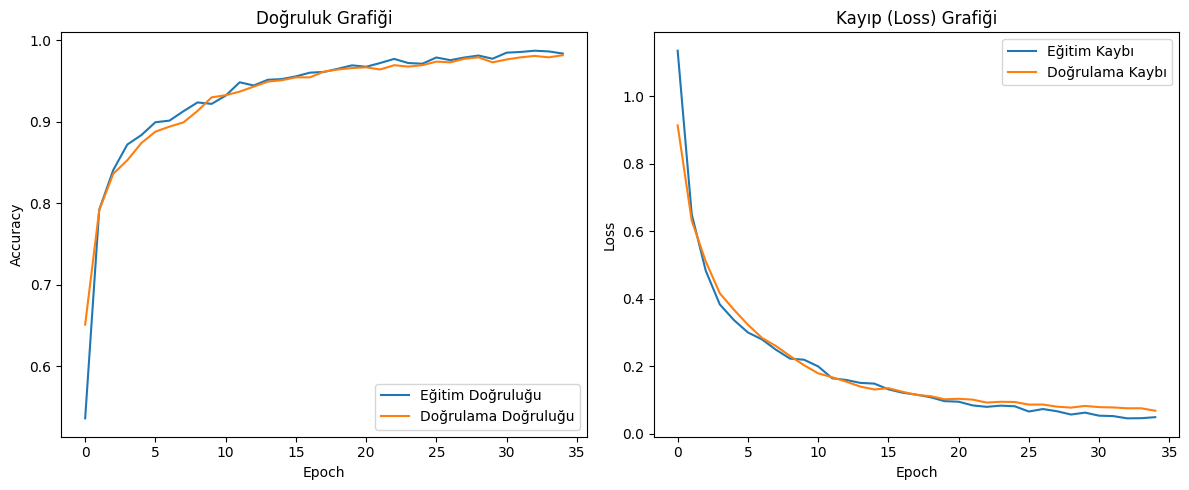

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Graphic')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Graphic')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(r"Your_Saving_Path/accuracy_loss_graph.png")
plt.show()


In [47]:
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_names = list(test_data.class_indices.keys())


41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 390ms/step


In [ ]:
from sklearn.metrics import classification_report

# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)  

with open("Your_Output_Path/classification_report.txt", "w") as f:
    f.write(report)



              precision    recall  f1-score   support

      glioma       0.99      0.94      0.96       300
  meningioma       0.95      0.97      0.96       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step


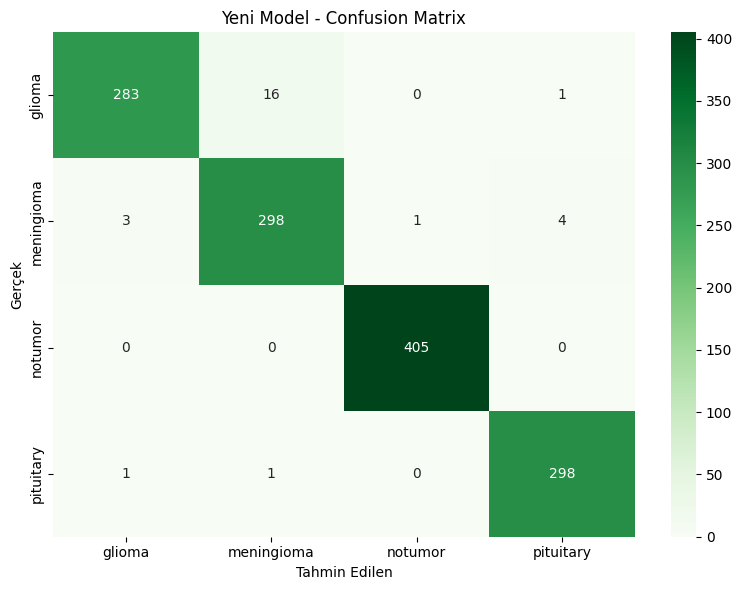

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes
class_labels = list(test_data.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Improved Model - Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig(r"Your_Saving_Path\confusion_matrix.png")
plt.show()



In [50]:
model.save("brain_tumor_finetuned.keras")
